## ML MIPT Practical 3

### 0. Введение и план

В данном домашнем задании будем решать задачу классификации отзывов.

Шаги решения:

1. Извлечение признаков: код для создания TF-IDF матрицы из представленного корпуса отзывов
2. Обучение моделей: код для обучения SVM и логистической регрессии
3. Кросс-валидация для подбора гиперпараметров: код для оптимизации метрик обучения
4. Участие в контесте на kaggle.com

#### Подготовка

Сперва импортируем нужные библиотеки и определим функцию res_matrix, которая по y_pred для каждого сэмпла будет выдавать соответствующее константное распределение.

In [11]:
import random
import math
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from random import shuffle
from cs231n.classifiers.linear_classifier import Softmax, LinearSVM
from IPython.display import Image
from cs231n.classifiers.linear_svm import svm_loss_naive, svm_loss_vectorized
from cs231n.classifiers.softmax import softmax_loss_naive, softmax_loss_vectorized
from cs231n.gradient_check import grad_check_sparse
from sklearn.metrics import classification_report, log_loss
from sklearn.cross_validation import train_test_split


%matplotlib inline
mpl.rc("savefig", dpi=300)
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

def res_matrix(pred):
    """Returns constant distribution for each element of pred."""
    results_matrix = np.zeros((len(pred), 4))
    results_matrix[np.arange(len(pred)), pred] = 1
    return results_matrix

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Считываем и знакомимся с данными

In [4]:
data = pd.read_csv('kaggle_data/train.csv', index_col=0, na_values='NaN')
print("Data shape is" + str(data.shape))
print(data.head())
documents = data["Reviews_Summary"].values
score = data["Prediction"].values
ids = data.index.values

Data shape is(352278, 2)
                                          Reviews_Summary  Prediction
ID                                                                   
230872                                  Babies love these           3
344823                                       Salmon Trout           0
211754                                     disappointment           1
259421  Doesn't taste like Cinnabon; tastes like Waffl...           2
253418  Delicious San Daniele prosciutto and good cust...           3


Как видите, каждый объект представляет собой отзыв о продукте и оценку по шкале от 0 до 3. Выдвинем гипотезу, что слова, используемые в написании отзыва коррелируют с оценкой, которая была поставлена. Поставим задачу - предсказать оценку по тексту отзыва.

### 1. Извлечение признаков - 10 Баллов
 

Для решения задачи классификации необходимо преобразовать каждый отзыв (документ) в вектор. Размерность данного вектора будет равна количеству слов используемых в корпусе (все документы). Каждая координата соответствует слову, значение в координает равно количеству раз, слово используется в документе. 

Для решения данной задачи нам нужно написать код, который преобразовывает документы в численную матрицу.

Дополнительная информация:

- Подробнее про векторное представление документов: http://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction
- Используем данный трансформер: http://scikit-learn.org/stable/modules/feature_extraction.html#common-vectorizer-usage
- Подробнее про разреженные матрицы: http://docs.scipy.org/doc/scipy-0.14.0/reference/sparse.html
- Hashing trick: https://en.wikipedia.org/wiki/Feature_hashing

Сначала воспользуемся CountVectorizer чтобы превратить предложения в вектора. Затем посчитаем распределение частотности слов. Заметим, что мы передели CountVectorizer параметр stop_words='english', поэтому все английские стоп слова будут выкинуты.

Total num words: 26798


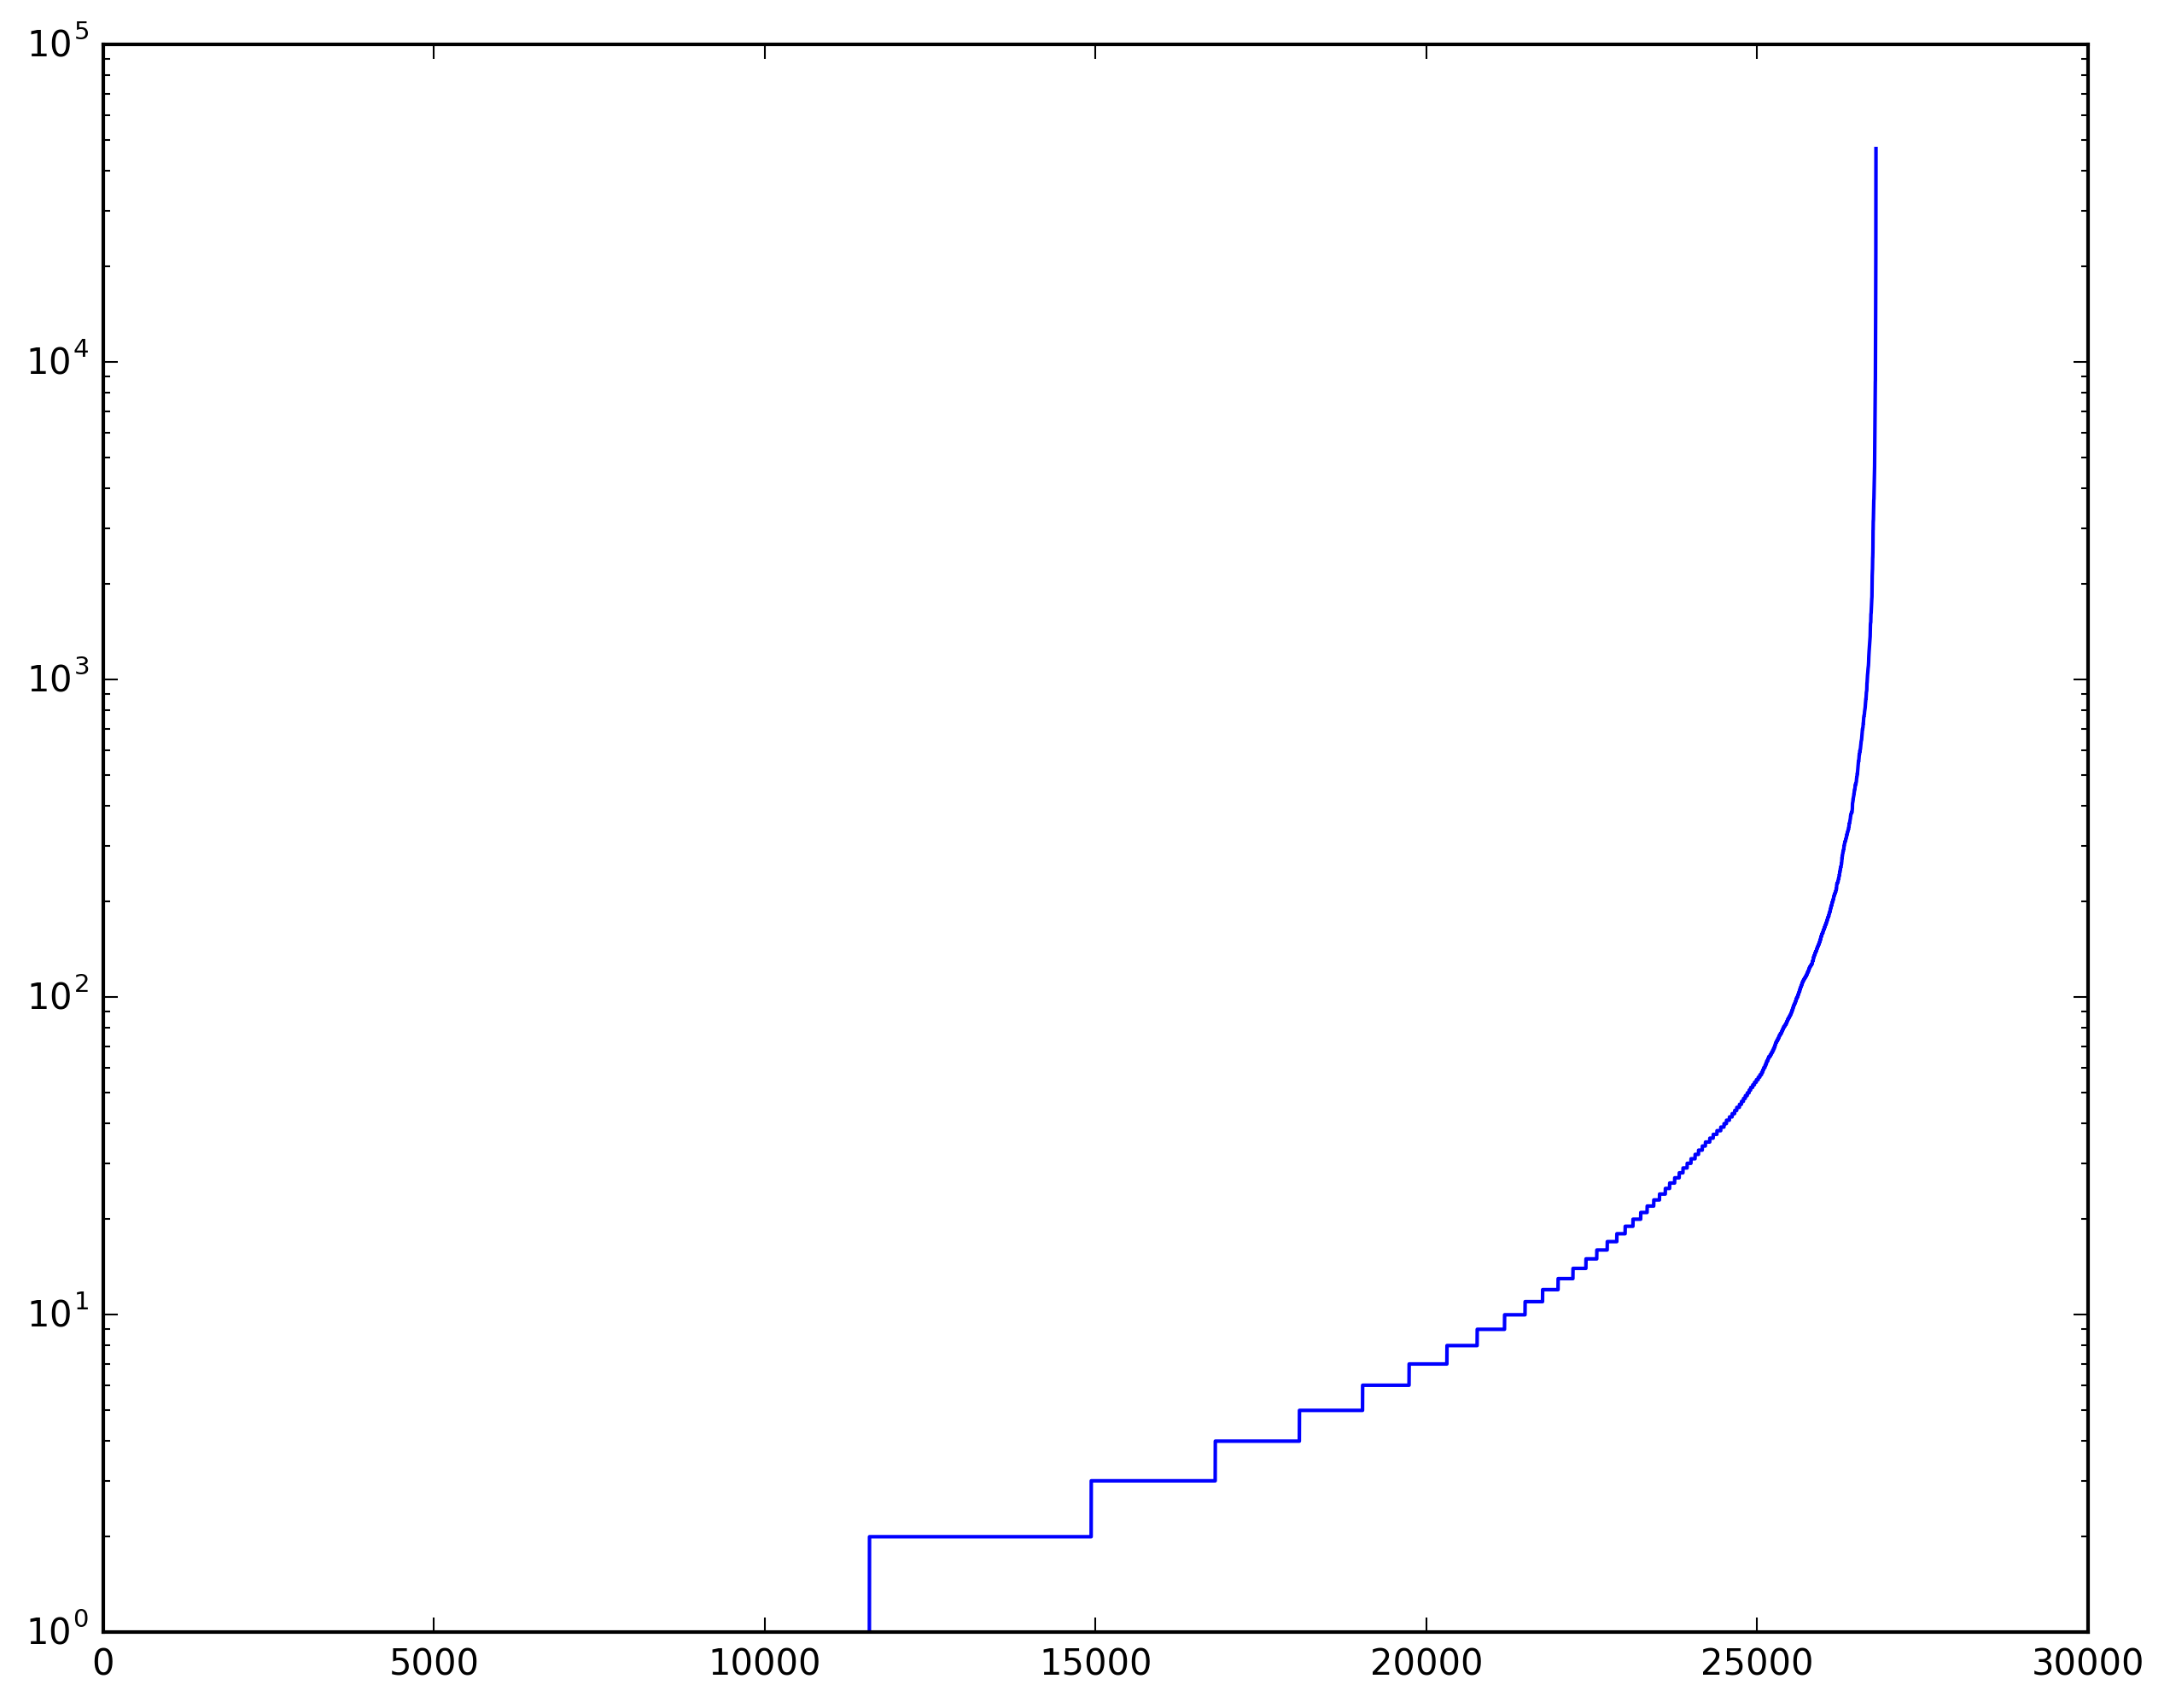

In [6]:
vectorizer = CountVectorizer(min_df=1, stop_words='english')
documents_vectorized = vectorizer.fit_transform(documents)
print("Total num words: %d" % documents_vectorized.shape[1])
d = dict()
for sentence in map(vectorizer.build_analyzer(), documents):
    for word in sentence:
        if word not in d:
            d[word] = 0
        d[word] += 1
plt.plot(sorted(list(d.values())))
plt.yscale('log')

Как видно всего слов получилось 26798, но большая их часть встреается в тексте предложении суммарно меньше 10 раз, поэтому можно оставить только 4000 значимых слов (max_features=4000).

Для учета важности редких, но показательных слов (термов), используется схема взвешивания TF-IDF. Напишем код, принимающий на вход разреженную матрицу векторного представления документов и возвращающий разреженную матрицу документов, частоты термов которых взвешенны по TF-IDF.

Дополнительная информация:

- Подробнее про TF-IDF: https://en.wikipedia.org/wiki/Tf%E2%80%93idf
- Используем этот трансформер: http://scikit-learn.org/stable/modules/feature_extraction.html#tfidf-term-weighting

В параметры TfidfTransformer передаем norm='l2', чтобы итоговые вектора были нормированны в пространстве L2

In [8]:
vectorizer = CountVectorizer(min_df=1, stop_words='english', max_features=4000)
documents_vectorized = vectorizer.fit_transform(documents)

transformer = TfidfTransformer(norm='l2')
documents_tfidf = transformer.fit_transform(documents_vectorized)

documents_tfidf = documents_tfidf.toarray()

Разобъем обучающую выборку на 2 части train и test

Используем трансформер http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.train_test_split.html#sklearn.cross_validation.train_test_split.

Транспонируем матрицы с данными, т.к. так будет проще реализовать код SVM.

In [13]:
X_train, X_test, y_train, y_test = train_test_split(documents_tfidf, score)
X_train = X_train.T
X_test = X_test.T
print("X_train shape is " + str(X_train.shape))
print("X_test shape is " + str(X_test.shape))

X_train shape is (4000, 264208)
X_test shape is (4000, 88070)


Возьмем подвыборки из обучающей выборки, для быстрой проверки кода.

In [16]:
X_train_sample = X_train[:, 0:100000]
y_train_sample = y_train[0:100000]
print("X_train_sample shape is " + str(X_train_sample.shape))

X_train_sample shape is (4000, 100000)


#### Замечание

Когда я первый раз воспользовался `train_test_split`, я использовал все $26798$ слов, вместо $4000$. Оно конечно, не сработало :), но когда я полез разбираться, я заметил, что python отобрал для себя 60 GB оперативной памяти (!), учитывая, что у меня в макбуке всего 8. Так я для себя открыл, что ядро OSX умеет сжимать память на лету, что оказалось довольно полезной фишкой, учитывая, что все мои numpy.array были разряженными. Кстати, быстрый гуглеж показал, что Microsoft в Windows 10 тоже добавила такую фичу.

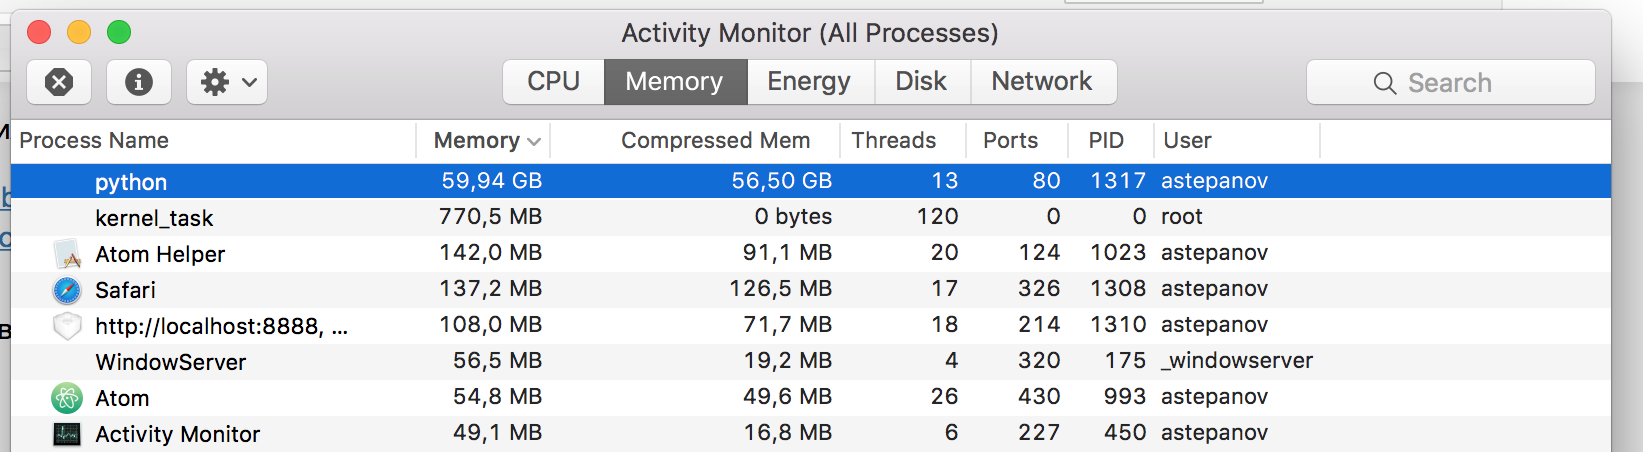

In [15]:
Image('memory_fail.png')

------

### 2. Код для SVM и логистической регресии - 40 Баллов

После того, как мы получили матрицу признаков, нам необходимо реализовать алгоритм обучения SVM и логистической регрессии. Обе модели являются линейными и отличаются функциями потерь. Для решения оптимизационных задач в обеих моделей будет использоваться стохастический градиентный спуск.

Дополнительная информация тут:

- Линейные модели: http://cs231n.github.io/linear-classify/
- SGD: http://cs231n.github.io/optimization-1

Начнем с SVM, функция потерь и вычисления градиента находятся в cs231n/classifiers/linear_svm.py.

Найдем чему равен градиент:

In [28]:
# generate a random SVM weight matrix of small numbers
W = np.random.randn(4, X_train_sample.shape[0]) * 0.01
%time loss, _ = svm_loss_naive(W, X_train_sample, y_train_sample, 0.00001)
print('loss: %f' % loss)

CPU times: user 4.16 s, sys: 72.3 ms, total: 4.23 s
Wall time: 3.83 s
loss: 3.000355


Реализуем наивную версию расчета градиента и проверем результат с помощью численного метода расчета. Градиенты должны почти совпадать.

In [29]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Compute the loss and its gradient at W.
loss, grad = svm_loss_naive(W, X_train_sample, y_train_sample, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
f = lambda w: svm_loss_naive(w, X_train_sample, y_train_sample, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 5)

numerical: 0.000414 analytic: 0.000414, relative error: 3.739291e-08
numerical: 0.000003 analytic: 0.000003, relative error: 8.112045e-06
numerical: 0.000122 analytic: 0.000122, relative error: 2.275272e-07
numerical: 0.000066 analytic: 0.000066, relative error: 2.079930e-07
numerical: 0.000010 analytic: 0.000010, relative error: 2.323062e-06


Теперь рализуем векторизированную версию расчета фунции потерь - svm_loss_vectorized

In [30]:
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_train_sample, y_train_sample, 0.00001)
toc = time.time()
print('Naive loss: %e computed in %fs' % (loss_naive, toc - tic))


tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_train_sample, y_train_sample, 0.00001)
toc = time.time()
print('Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference: %f' % (loss_naive - loss_vectorized))

Naive loss: 3.000355e+00 computed in 4.966810s
Vectorized loss: 3.000355e+00 computed in 0.839398s
difference: 0.000000


Завершим реализацию SVM векторизированной функцией подсчета градиента.

In [31]:
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_train_sample, y_train_sample, 0.00001)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_train_sample, y_train_sample, 0.00001)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)

Naive loss and gradient: computed in 3.851424s
Vectorized loss and gradient: computed in 0.724998s
difference: 0.000000


### Stochastic Gradient Descent

In [29]:
# Now implement SGD in LinearSVM.train() function and run it with the code below
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=5e-2, reg=0.01,
                      num_iters=500, verbose=True, batch_size=20000)

toc = time.time()
print('That took %fs' % (toc - tic))
print('Current loss is %f' % loss_hist[-1])

iteration 0 / 500: loss 3.000431
iteration 10 / 500: loss 2.963029
iteration 20 / 500: loss 2.924825
iteration 30 / 500: loss 2.890376
iteration 40 / 500: loss 2.854650
iteration 50 / 500: loss 2.817048
iteration 60 / 500: loss 2.785447
iteration 70 / 500: loss 2.751773
iteration 80 / 500: loss 2.718107
iteration 90 / 500: loss 2.690358
iteration 100 / 500: loss 2.649087
iteration 110 / 500: loss 2.626280
iteration 120 / 500: loss 2.596154
iteration 130 / 500: loss 2.566217
iteration 140 / 500: loss 2.542896
iteration 150 / 500: loss 2.513205
iteration 160 / 500: loss 2.503563
iteration 170 / 500: loss 2.477006
iteration 180 / 500: loss 2.439487
iteration 190 / 500: loss 2.436061
iteration 200 / 500: loss 2.408822
iteration 210 / 500: loss 2.397091
iteration 220 / 500: loss 2.376438
iteration 230 / 500: loss 2.367770
iteration 240 / 500: loss 2.347302
iteration 250 / 500: loss 2.349161
iteration 260 / 500: loss 2.341841
iteration 270 / 500: loss 2.321007
iteration 280 / 500: loss 2.317

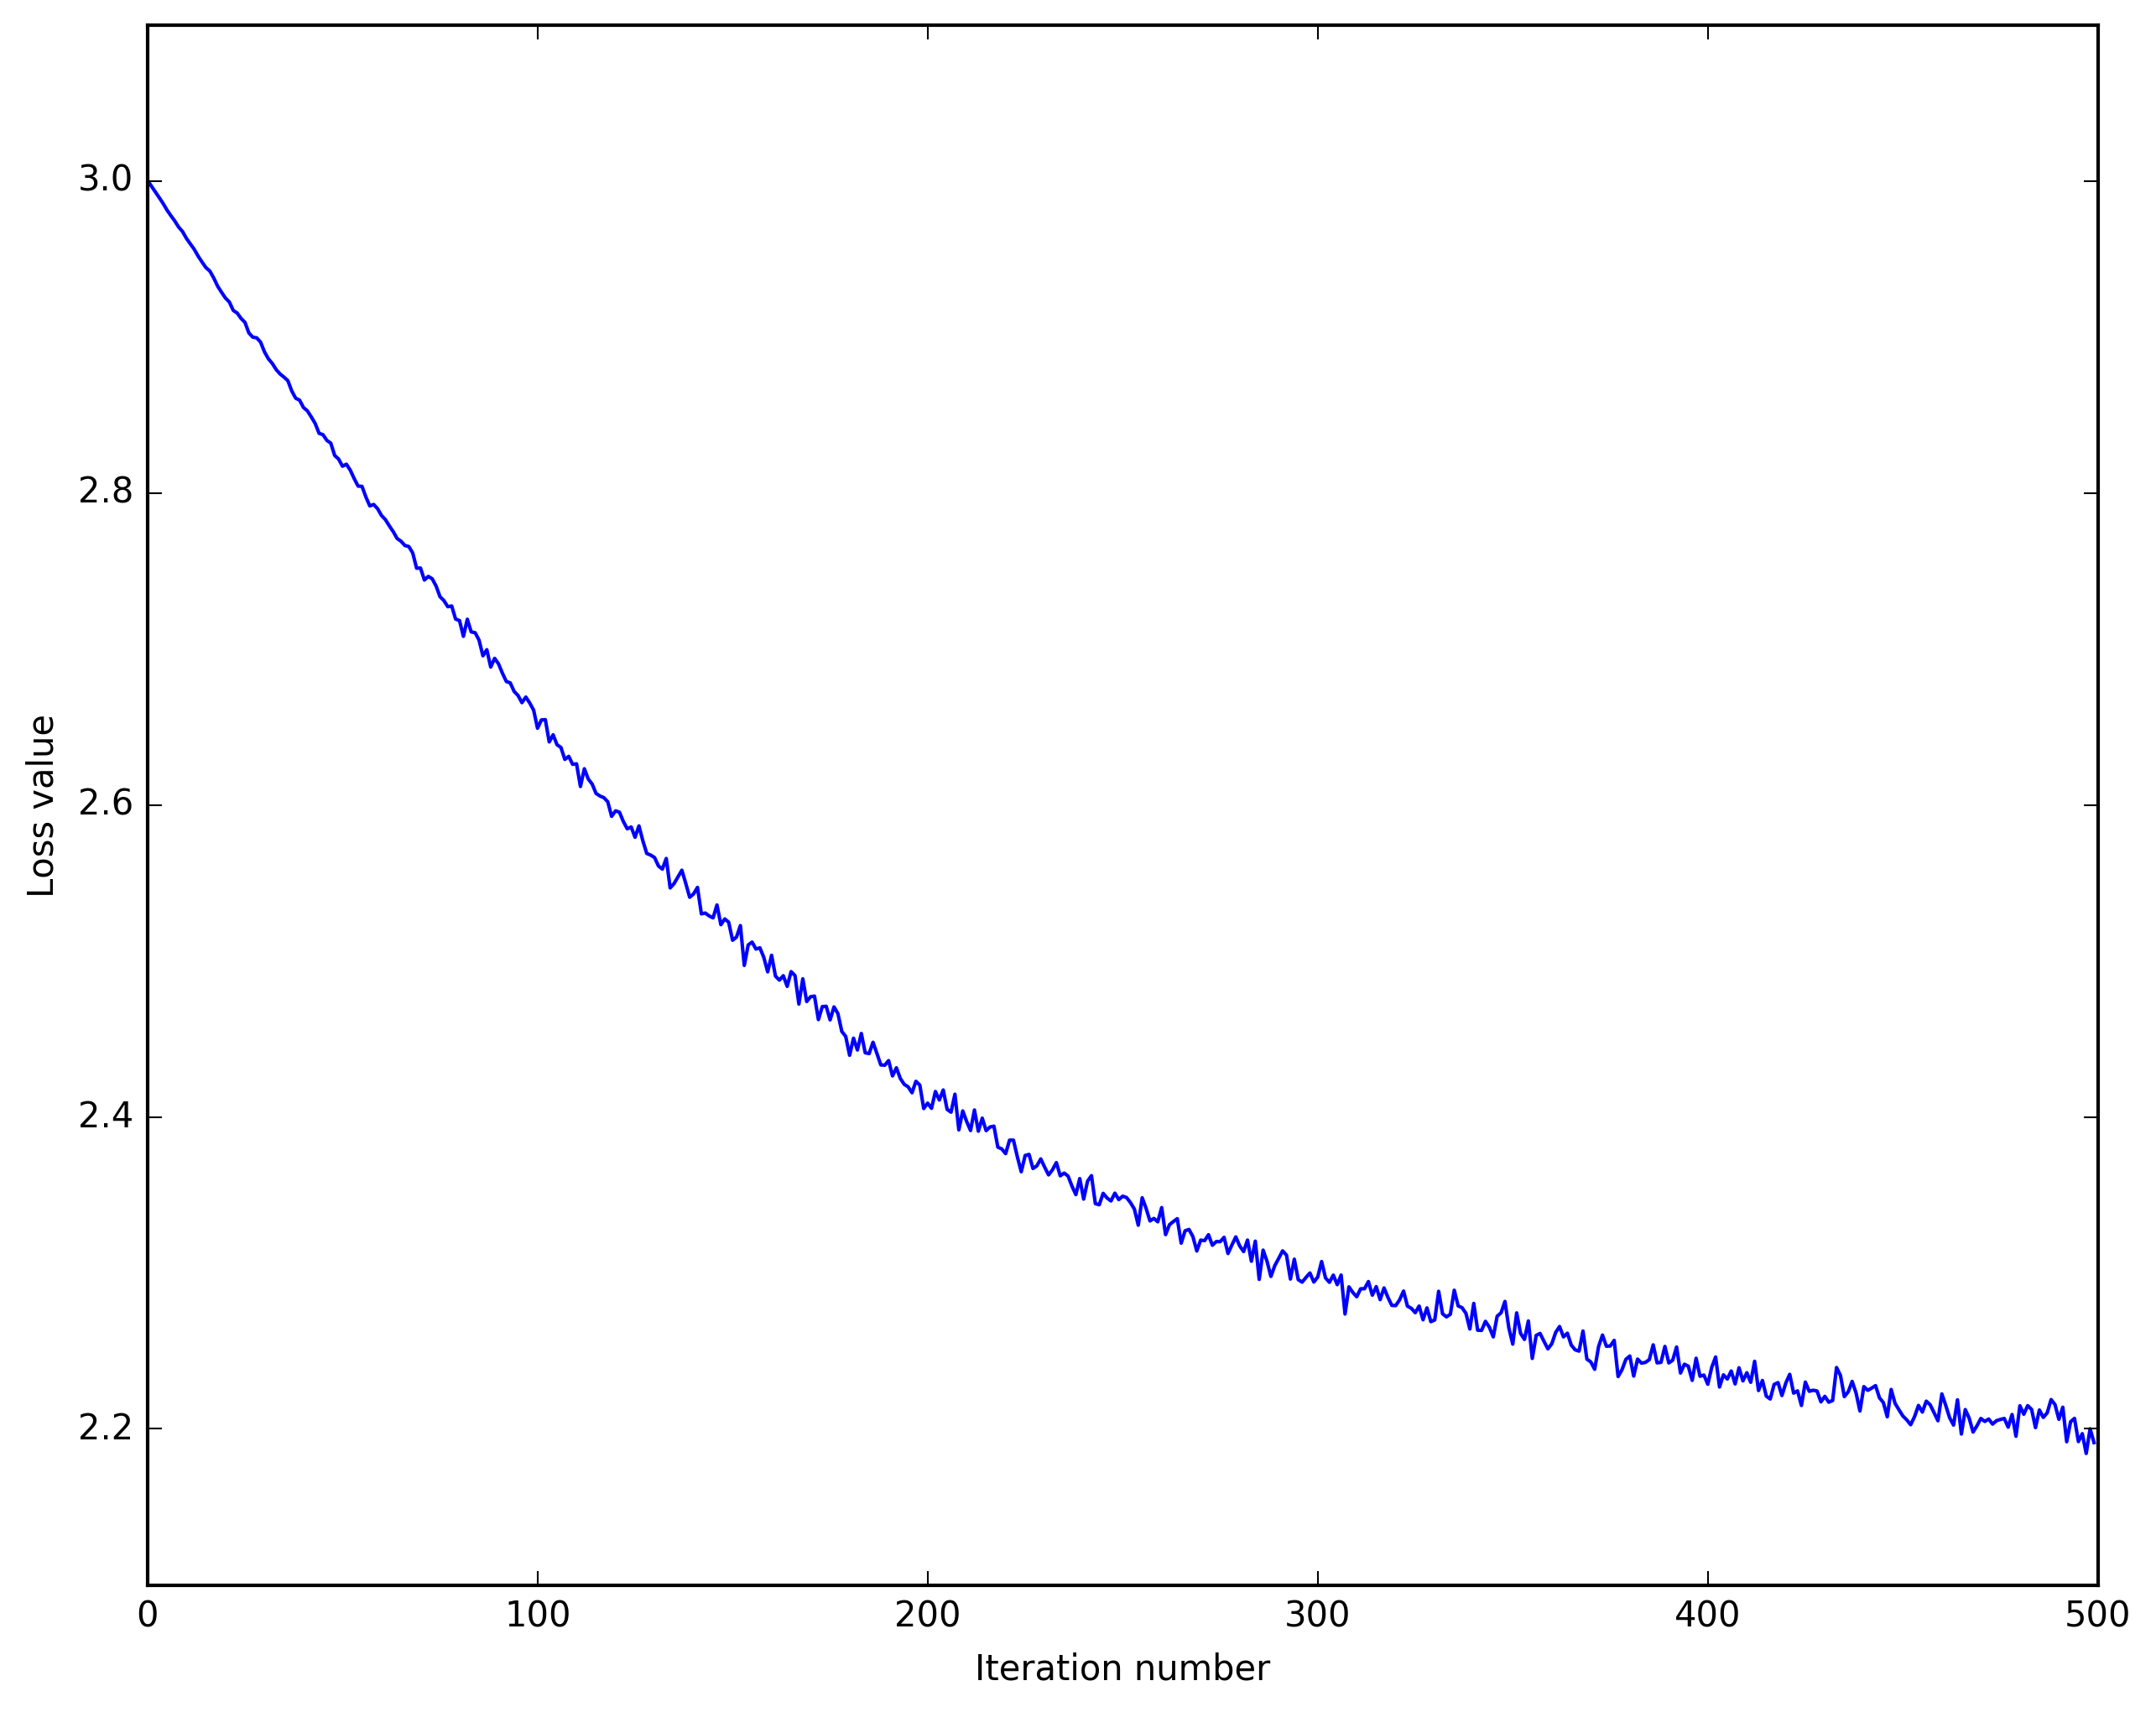

In [30]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')

In [31]:
# Write the LinearSVM.predict function 
y_train_pred = svm.predict(X_train)
y_test_pred = svm.predict(X_test)

In [33]:
print(classification_report(y_test, y_test_pred))

             precision    recall  f1-score   support

          0       0.46      0.30      0.37     15125
          1       0.57      0.04      0.07      8709
          2       0.35      0.01      0.02     23313
          3       0.72      0.97      0.83    105131

avg / total       0.63      0.70      0.61    152278



In [35]:
log_loss(y_test, res_matrix(y_test_pred))

10.265373073308442

In [34]:
# compare result with the most common dummy classifier
print(classification_report(y_test, [3]*len(y_test)))

             precision    recall  f1-score   support

          0       0.00      0.00      0.00     15125
          1       0.00      0.00      0.00      8709
          2       0.00      0.00      0.00     23313
          3       0.69      1.00      0.82    105131

avg / total       0.48      0.69      0.56    152278



/Users/astepanov/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


--------

## Softmax Classifier

In [40]:
# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(4, X_train_sample.shape[0]) * 0.01 
loss, grad = softmax_loss_naive(W, X_train_sample, y_train_sample, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 1.386373
sanity check: 2.302585


In [43]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_train_sample, y_train_sample, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
f = lambda w: softmax_loss_naive(w, X_train_sample, y_train_sample, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 5)

numerical: 0.000045 analytic: 0.000045, relative error: 6.359250e-08
numerical: 0.000004 analytic: 0.000004, relative error: 6.421433e-07
numerical: -0.000065 analytic: -0.000065, relative error: 5.398681e-08
numerical: 0.000015 analytic: 0.000015, relative error: 3.349736e-07
numerical: 0.000009 analytic: 0.000009, relative error: 1.979686e-07


In [45]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_train_sample, y_train_sample, 0.00001)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_train_sample, y_train_sample, 0.00001)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 1.386385e+00 computed in 0.534020s
vectorized loss: 1.386385e+00 computed in 0.540442s
Loss difference: 0.000000
Gradient difference: 0.000000


In [30]:
sm = Softmax()
tic = time.time()
loss_hist = sm.train(X_train, y_train, learning_rate=5e-2, reg=0.001,
                      num_iters=4000, verbose=True, batch_size=3000)

toc = time.time()
print('That took %fs' % (toc - tic))
print('Current loss is %f' % loss_hist[-1])

iteration 0 / 1500: loss 1.386222
iteration 10 / 1500: loss 1.383885
iteration 20 / 1500: loss 1.381605
iteration 30 / 1500: loss 1.379292
iteration 40 / 1500: loss 1.377269
iteration 50 / 1500: loss 1.374463
iteration 60 / 1500: loss 1.372481
iteration 70 / 1500: loss 1.370170
iteration 80 / 1500: loss 1.368022
iteration 90 / 1500: loss 1.366204
iteration 100 / 1500: loss 1.363914
iteration 110 / 1500: loss 1.360519
iteration 120 / 1500: loss 1.358738
iteration 130 / 1500: loss 1.356899
iteration 140 / 1500: loss 1.354812
iteration 150 / 1500: loss 1.352333
iteration 160 / 1500: loss 1.350700
iteration 170 / 1500: loss 1.349026
iteration 180 / 1500: loss 1.346706
iteration 190 / 1500: loss 1.344716
iteration 200 / 1500: loss 1.340547
iteration 210 / 1500: loss 1.340735
iteration 220 / 1500: loss 1.335918
iteration 230 / 1500: loss 1.336595
iteration 240 / 1500: loss 1.334441
iteration 250 / 1500: loss 1.332312
iteration 260 / 1500: loss 1.330156
iteration 270 / 1500: loss 1.329624
ite

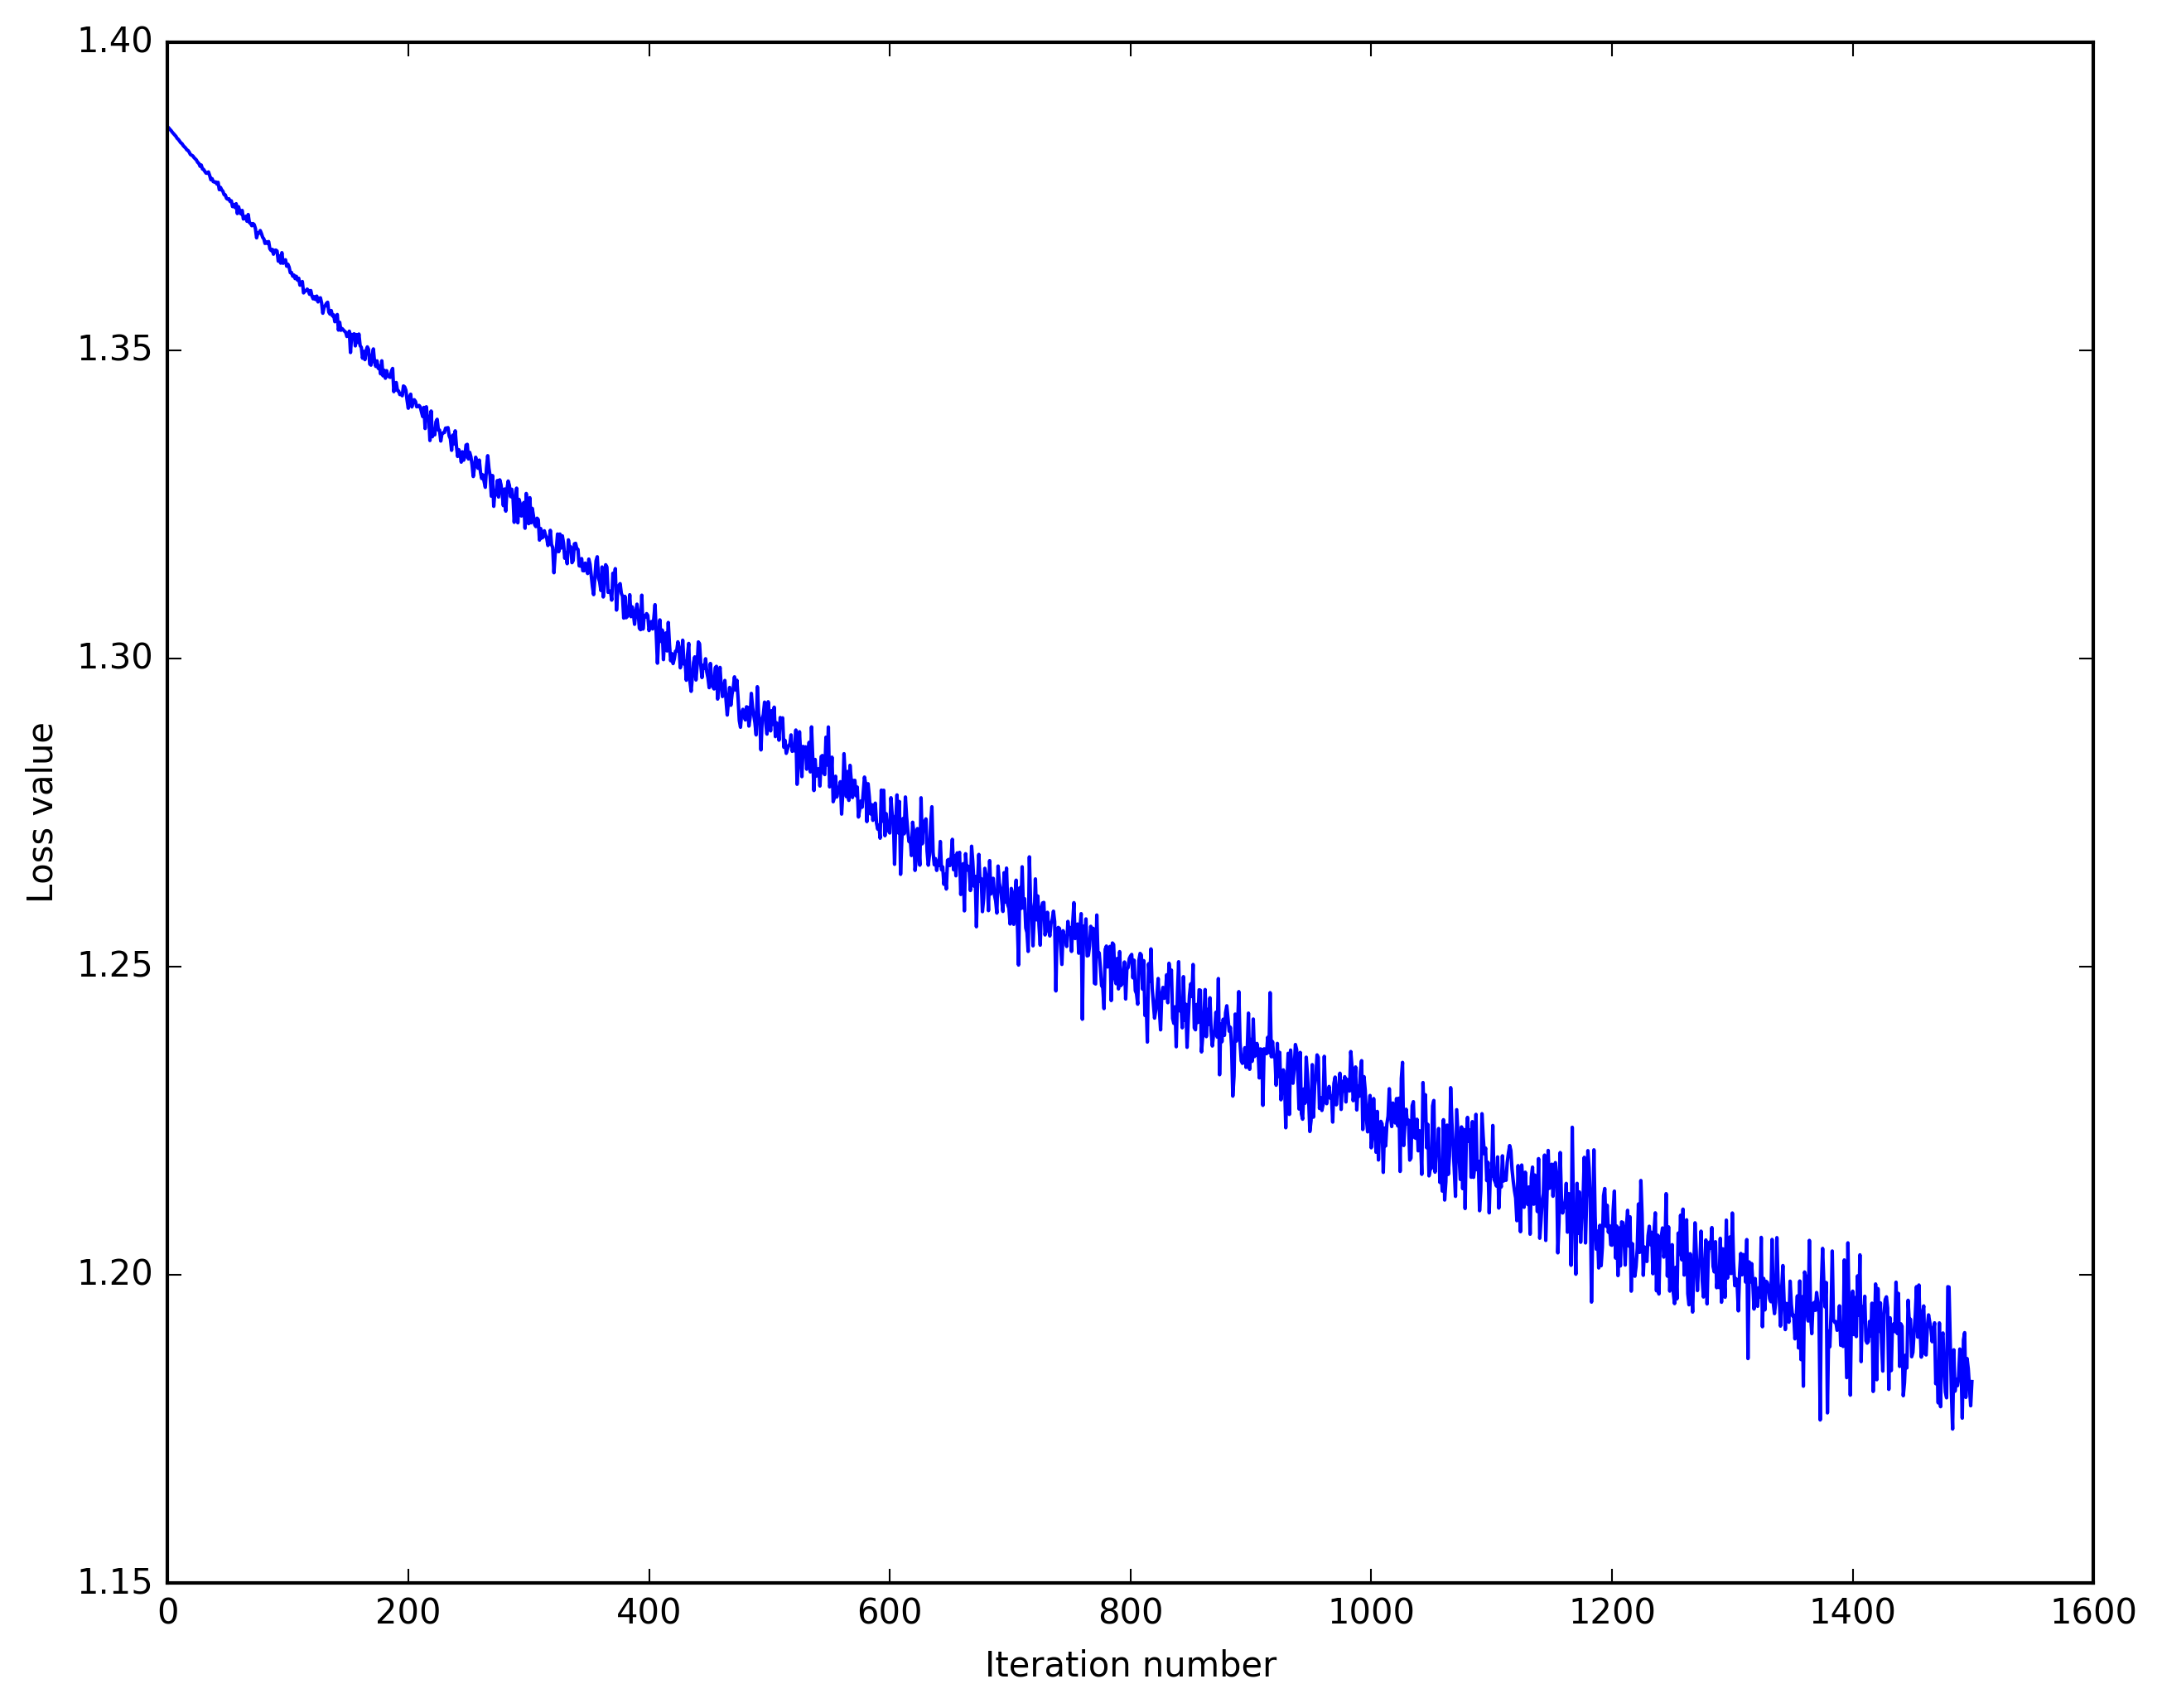

In [31]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [32]:
# Write the LinearSVM.predict function 
y_train_pred = sm.predict(X_train)
y_test_pred = sm.predict(X_test)

In [33]:
print(classification_report(y_test, y_test_pred))

             precision    recall  f1-score   support

          0       0.46      0.31      0.37     15337
          1       0.48      0.04      0.08      8735
          2       0.32      0.01      0.02     23373
          3       0.72      0.97      0.83    104833

avg / total       0.62      0.70      0.61    152278



In [34]:
log_loss(y_test, res_matrix(y_test_pred))

10.327520098697571

In [35]:
y_test_prob = sm.predict_prob(X_test)
log_loss(y_test, y_test_prob.T)

1.1704947228615881

In [36]:
y_test_prob.T[:50]

array([[ 0.24076118,  0.23219585,  0.24727504,  0.27976794],
       [ 0.25026074,  0.25134588,  0.24921606,  0.24917732],
       [ 0.20735883,  0.20529822,  0.24632612,  0.34101682],
       [ 0.21466405,  0.21673834,  0.24835728,  0.32024033],
       [ 0.21722089,  0.21794624,  0.22375083,  0.34108204],
       [ 0.19791224,  0.19503107,  0.21574775,  0.39130893],
       [ 0.17525413,  0.17693203,  0.20378128,  0.44403255],
       [ 0.14387823,  0.14469881,  0.28317088,  0.42825208],
       [ 0.23760006,  0.23712792,  0.24372159,  0.28155043],
       [ 0.25019014,  0.24420305,  0.24664159,  0.25896522],
       [ 0.2413945 ,  0.24023898,  0.24509564,  0.27327088],
       [ 0.2493033 ,  0.25008683,  0.25042368,  0.25018619],
       [ 0.18670984,  0.1832325 ,  0.20048954,  0.42956812],
       [ 0.24960641,  0.24950829,  0.25010258,  0.25078271],
       [ 0.24454572,  0.24152725,  0.24438296,  0.26954407],
       [ 0.19376658,  0.19401308,  0.20741425,  0.40480609],
       [ 0.23957312,  0.

In [65]:
# compare result with the most common dummy classifier
print(classification_report(y_test, [3]*len(y_test)))

             precision    recall  f1-score   support

          0       0.00      0.00      0.00     15125
          1       0.00      0.00      0.00      8709
          2       0.00      0.00      0.00     23313
          3       0.69      1.00      0.82    105131

avg / total       0.48      0.69      0.56    152278



/Users/astepanov/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


------

### 3. Kaggle In Class - 50 Баллов

Используйте полученные модели для решения контеста. Выберете одну из моделей, реализуйте настройку гиперпараметров и пайплайн для предсказания классов тестовой выборки для сабмита в систему.

In [29]:
sm = Softmax()
tic = time.time()
loss_hist = sm.train(documents_tfidf.T, score, learning_rate=4, reg=0,
                      num_iters=10000, verbose=True, batch_size=1000)

toc = time.time()
print('That took %fs' % (toc - tic))
print('Current loss is %f' % loss_hist[-1])

iteration 0 / 10000: loss 1.386286, best_loss: 1.386286
iteration 100 / 10000: loss 0.928224, best_loss: 0.928180
iteration 200 / 10000: loss 0.950259, best_loss: 0.848835
iteration 300 / 10000: loss 0.890297, best_loss: 0.818677
iteration 400 / 10000: loss 0.835410, best_loss: 0.806731
iteration 500 / 10000: loss 0.824906, best_loss: 0.760222
iteration 600 / 10000: loss 0.824057, best_loss: 0.760222
iteration 700 / 10000: loss 0.797993, best_loss: 0.748875
iteration 800 / 10000: loss 0.789260, best_loss: 0.739457
iteration 900 / 10000: loss 0.759832, best_loss: 0.718924
iteration 1000 / 10000: loss 0.779668, best_loss: 0.718924
iteration 1100 / 10000: loss 0.740704, best_loss: 0.708417
iteration 1200 / 10000: loss 0.784239, best_loss: 0.708417
iteration 1300 / 10000: loss 0.751946, best_loss: 0.689087
iteration 1400 / 10000: loss 0.777123, best_loss: 0.689087
iteration 1500 / 10000: loss 0.774657, best_loss: 0.689087
iteration 1600 / 10000: loss 0.776910, best_loss: 0.689087
iteration

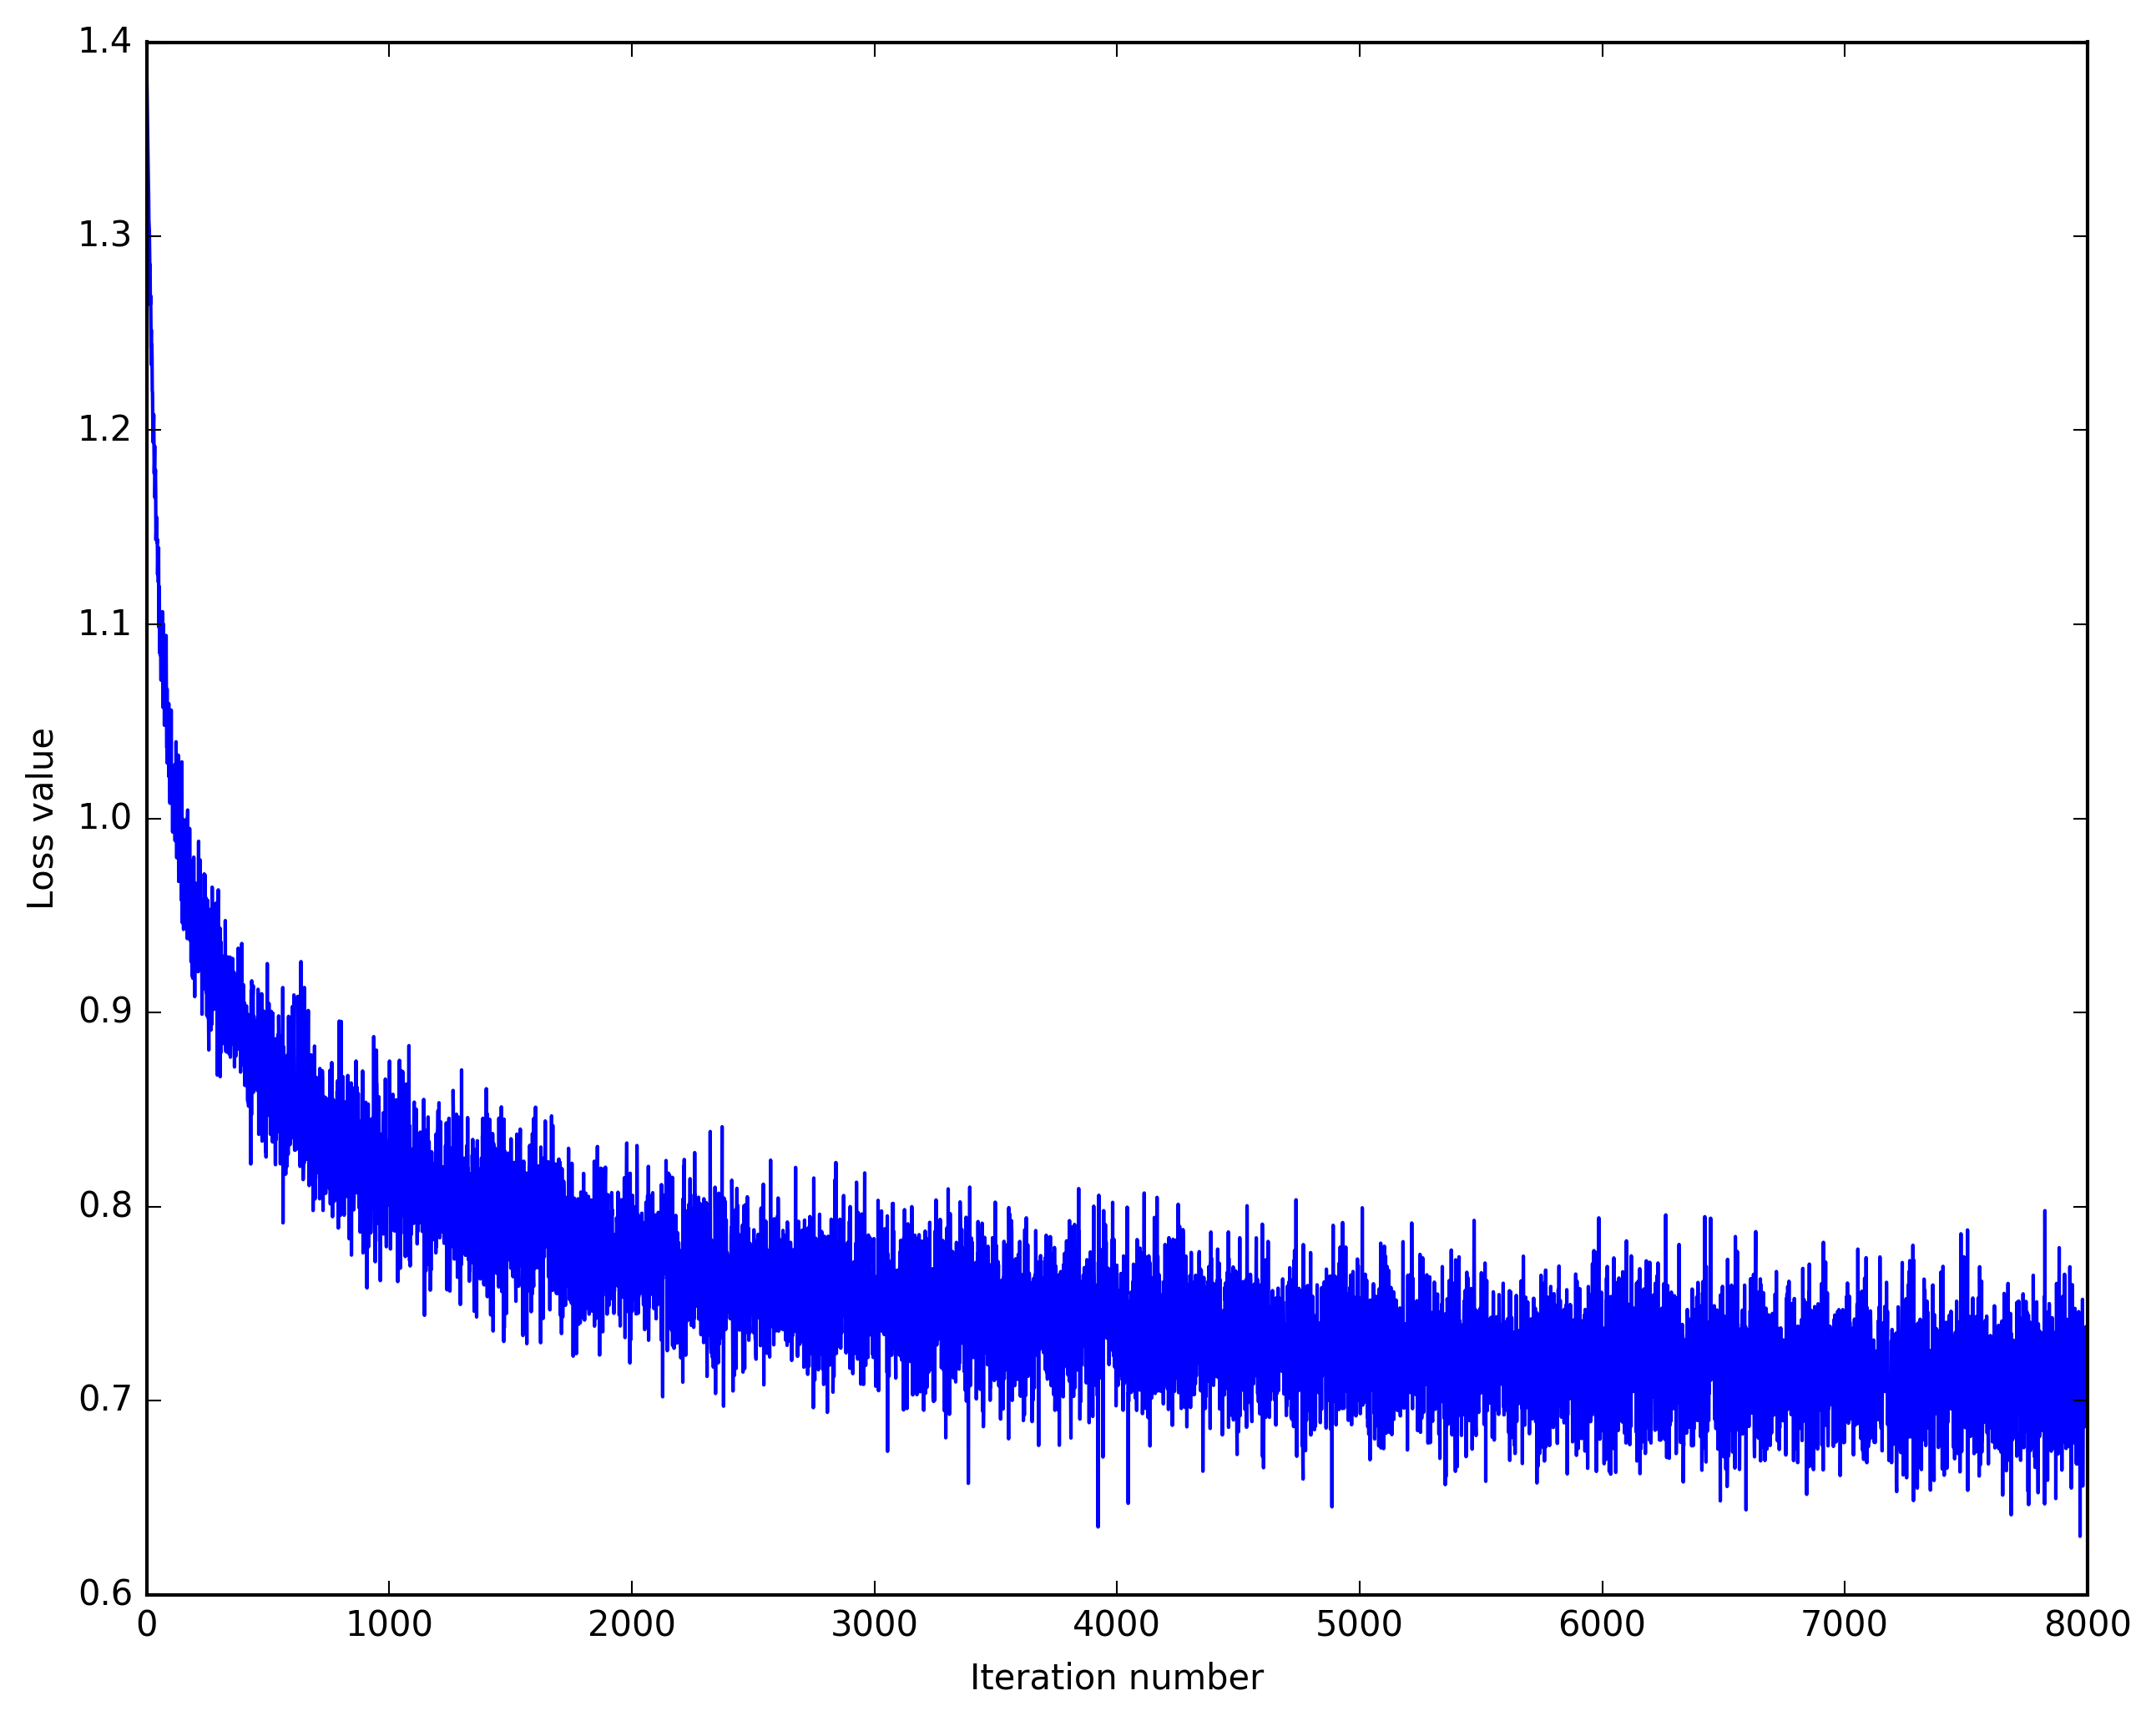

In [23]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [33]:
test = pd.read_csv('kaggle_data/test.csv', index_col=0, na_values='NaN')
documents_test = test["Reviews_Summary"].values
ids_test = test.index.values.reshape((-1,))
test_array = transformer.transform(vectorizer.transform(documents_test)).toarray()
pred = sm.predict_prob(test_array.T)
results_matrix = pred.T
ans = pd.DataFrame(results_matrix)
ans.index = ids_test
ans.index.name="Id"
ans.columns=["class_0", "class_1", "class_2", "class_3"]
ans.to_csv('kaggle_data/no_reg_softmax.csv')

In [34]:
for i in range(20):
    print(documents_test[i], pred.T[i])

CHECK THE SUGAR [ 0.35498816  0.1844971   0.20123322  0.25928151]
Great Product [ 0.00173419  0.00497572  0.12969912  0.86359097]
This stuff rocks! [ 0.01934014  0.00517018  0.02039551  0.95509417]
community coffee [ 0.10095795  0.10827473  0.2219015   0.56886581]
Not my favorite but good for you! [  6.62934603e-04   8.14098662e-03   7.80896151e-02   9.13106464e-01]
Great stuff [  8.18201397e-04   9.15763222e-04   6.79271217e-02   9.30338914e-01]
8 out of the 12 cans were seriously dented [ 0.6009051   0.18125893  0.06457611  0.15325986]
So Peachy [ 0.19264232  0.16671654  0.21280426  0.42783689]
Great caffeine laden tea [ 0.02084859  0.05605223  0.18237166  0.74072753]
Almonds with heat [ 0.05007373  0.05581153  0.1230032   0.77111154]
Gerber's fruits are cooked [ 0.42353446  0.17344927  0.11966498  0.2833513 ]
this vendor was gross [ 0.71992878  0.19178895  0.02983437  0.0584479 ]
Honest Tea Organic Peach White Tea Great Tea [ 0.01556995  0.01379555  0.18467867  0.78595583]
Best Flav

CHECK THE SUGAR [ 0.30255702  0.19253761  0.20276113  0.30214424]
Great Product [ 0.00299928  0.00547589  0.11034691  0.88117792]
This stuff rocks! [ 0.03436494  0.01351853  0.03934396  0.91277257]
community coffee [ 0.13401365  0.13145482  0.23993625  0.49459528]
Not my favorite but good for you! [ 0.00125239  0.00791571  0.0780503   0.9127816 ]
Great stuff [ 0.00135173  0.00165828  0.07317567  0.92381432]
8 out of the 12 cans were seriously dented [ 0.50819283  0.21086202  0.10534192  0.17560324]
So Peachy [ 0.21886163  0.20361249  0.23564265  0.34188323]
Great caffeine laden tea [ 0.00623212  0.01860553  0.13877248  0.83638988]
Almonds with heat [ 0.08783572  0.08612046  0.12490265  0.70114116]
Gerber's fruits are cooked [ 0.32694095  0.210427    0.17592703  0.28670503]
this vendor was gross [ 0.68115857  0.16692076  0.06497913  0.08694154]
Honest Tea Organic Peach White Tea Great Tea [ 0.01723525  0.01539259  0.16576346  0.8016087 ]
Best Flavor ... Best Price ... Best Way to Purchase! [ 0.00136815  0.00288866  0.02039916  0.97534404]
beautiful [ 0.05155911  0.05898272  0.10003831  0.78941986]
Tommy Moloneys [ 0.25  0.25  0.25  0.25]
Italian Meatballs - Easy to Prepare & Delicious [ 0.00524326  0.00612714  0.13819502  0.85043458]
Not the best flavor but still good [ 0.00094446  0.00501385  0.0720988   0.92194289]
A tasty chai! [ 0.01893702  0.03349313  0.25836429  0.68920556]
Warm and Yummy [ 0.01764894  0.01947142  0.22482913  0.73805052]

------

### 4. Бонусы - 30 Баллов

Улучшите результат: 

- Нормализуйте слова в документах, используйте стоп слова, попробуйте различные стратегии нормализации в TF-IDF
- Используйте PCA, Word2Vec для расширения пространства фичей
- Придумайте другие стратегии и улучшайте свой результат